In [1]:
from pixell import reproject, enmap, utils, enplot
import numpy as np
# define a plotting function
def eshow(x,**kwargs): enplot.show(enplot.plot(x,**kwargs))
import healpy as hp
import coop_post_processing as cpp
import coop_setup_funcs as csf
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import wcs as astwcs
import sys
# autoreload
# instert path
%load_ext autoreload
%autoreload 2
sys.path.append("..")
import stacking_functions as sf


[1744036748.431500] [kingcrab:3314590:0]        ib_iface.c:1035 UCX  ERROR ibv_create_cq(cqe=4096) failed: Cannot allocate memory


[kingcrab:3314590] pml_ucx.c:309  Error: Failed to create UCP worker


In [16]:
# Define a function to show on the map where the clusters are:
def mask_srcs(shape,wcs,srcs,radius_arcmin):
    """
    from orphics.maps by Mathew S. Madhavacheril
    Create a mask of circular holes in rectangular pixelization given
    a set of coordinates and a hole radius.

    Parameters
    ----------
    shape : tuple
        Shape of the output mask to be generated.
    wcs : `astropy.wcs.WCS`
        WCS object describing the output mask.
    srcs_deg : float `numpy.ndarray` of shape (2, Nobj)
        An array of Nobj coordinates in (Dec,RA) order and in degrees.
    radius_arcmin : float
        The radius of the circular hole to mask with zeros at each
        object location.

    Returns
    -------
    mask : `pixell.enmap.ndmap`
        A boolean pixell enmap with geometry (shape,wcs) and False
        inside the circular holes and True outside.

    """
    r = np.deg2rad(radius_arcmin/60.)
    return enmap.distance_from(shape,wcs,srcs, rmax=r) >= r
     

In [17]:
diagline = enmap.read_map("/mnt/raid-cita/mlokken/data/diagonal_line_map.fits")
shape, wcs = diagline.geometry

In [18]:
# get the diag pixels
diag_pixels = []
for i in range(shape[0]):
    for j in range(30):
        diag_pixels.append([i, i+j])
        
# make some coordinates along one side of the diagonal line
dec, ra = enmap.pix2sky(shape, wcs, np.array(diag_pixels).T)
ra = ra[::1000][:10] # every 100th pixel, but only the first ten]
dec = dec[::1000][:10] # every 100th pixel, but only the first ten]

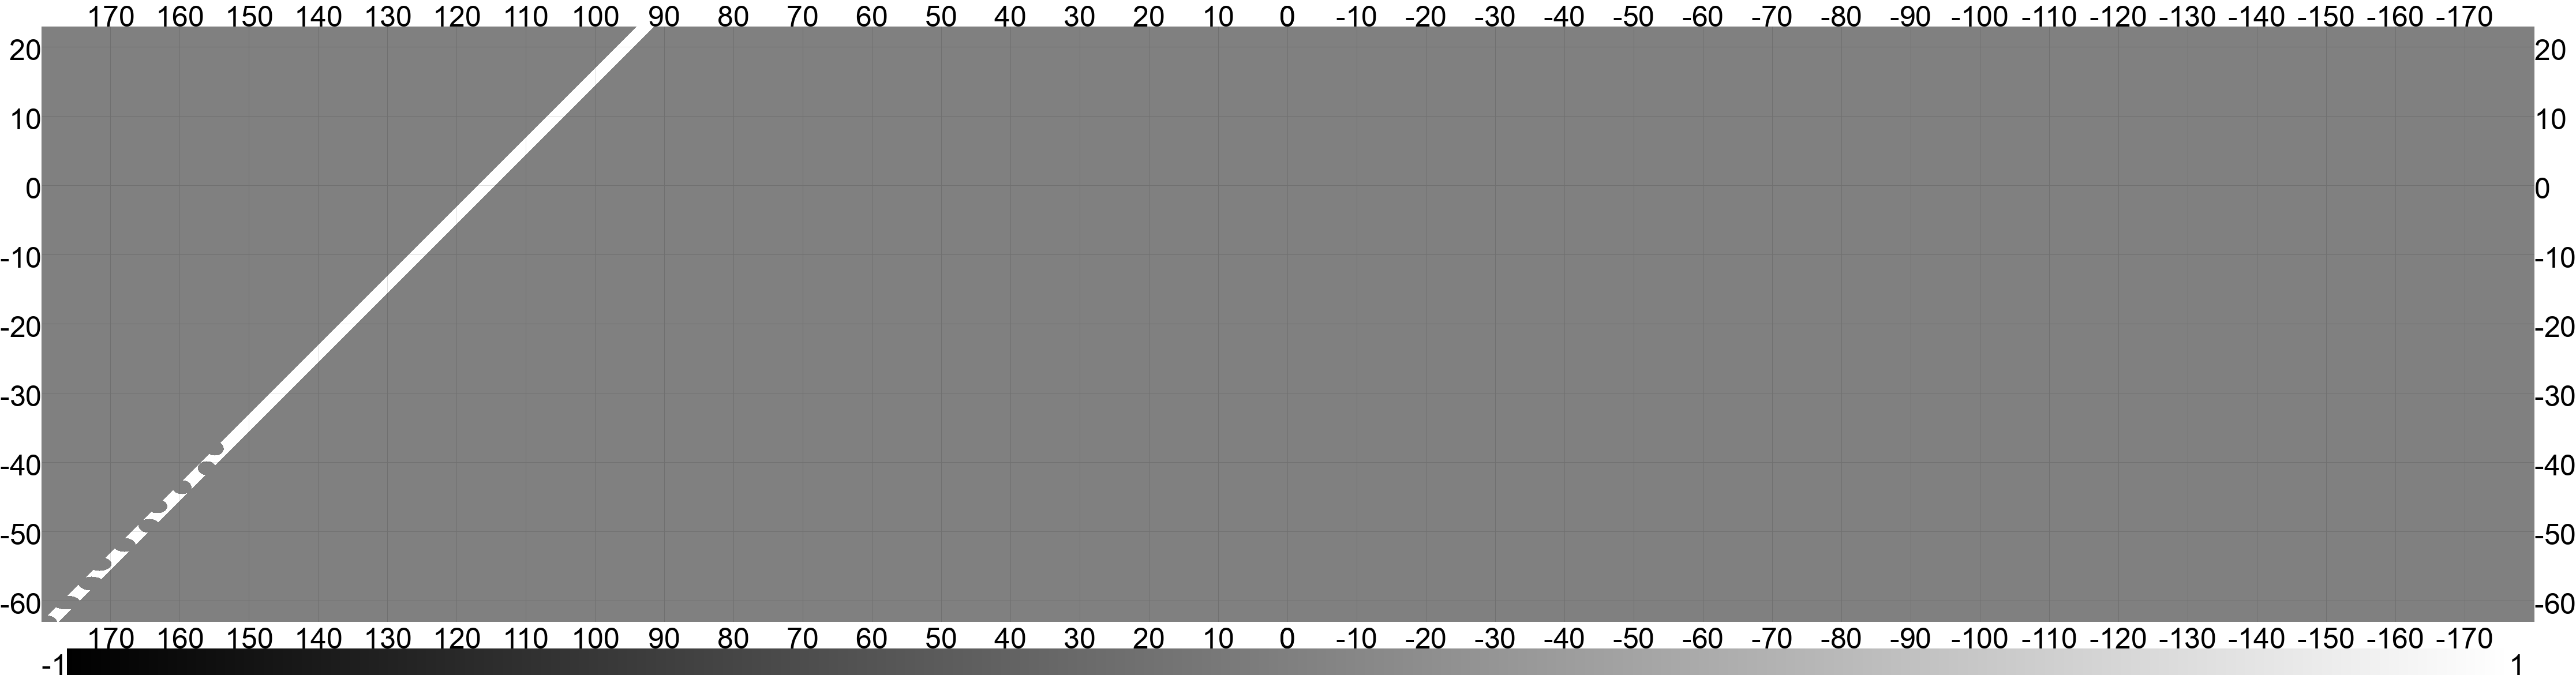

In [19]:
pt_visual = mask_srcs(shape,wcs,np.asarray((dec,ra)),60.)
eshow(pt_visual*diagline, ticks=10, colorbar=True, color='gray', font_size=50)

In [20]:
# save the points as both an (ra,dec) list and a (theta,phi) list
np.savetxt("testing_data/ra_dec_list_halfdiag.txt", np.asarray((np.rad2deg(ra),np.rad2deg(dec))).T)
healpix_theta = np.pi/2. - dec
healpix_phi = ra
np.savetxt("testing_data/theta_phi_list_halfdiag.txt", np.asarray((healpix_theta,healpix_phi)).T)

In [25]:
rot_angle,ra,dec, parityx, parityy, peakid = cpp.get_peakinfo("testing_data/halfdiag_line_map_pks_with_orientation_asym.fits")

FORMAT  =HEALPIX                                                                 [astropy.io.fits.card]
MAP     =/mnt/raid-cita/mlokken/data/diagonal_line_map_hpx.fits                  [astropy.io.fits.card]
FWHM    =0.                                                                      [astropy.io.fits.card]
OUTPUT  =/home/mlokken/oriented_stacking/oriented_superclustering/testing/testin [astropy.io.fits.card]
EXTERNAL=/home/mlokken/oriented_stacking/oriented_superclustering/testing/testin [astropy.io.fits.card]
NU_MIN  =-1.e30                                                                  [astropy.io.fits.card]
NU_MAX  =1.e30                                                                   [astropy.io.fits.card]
FWHM_NU =0.                                                                      [astropy.io.fits.card]
E_MIN   =0                                                                       [astropy.io.fits.card]
E_MAX   =1.e30                                                  

In [27]:
# stack the map
# flat line map

import stacking_functions as sf

# make a Chunk object
Chunk = sf.Chunk(ra, dec, rot_angle, parityx, parityy)

In [4]:
5/.5

10.0

In [35]:
cutout_size_deg = 10
cutout_resolution_deg = 0.5
orient = 'asymmetric'
stack = sf.stackChunk(Chunk, diagline, cutout_size_deg, cutout_resolution_deg, orient)


x_lrg shape is (43,) y_lrg shape is (43,) thumbnail shape is (43, 43)
- analyze object 0


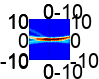

0.17453292519943295 6.0999257357201815 -0.17453292519943295 0.1832595714594046


In [36]:
eshow(stack, ticks=10)
# get min, max ra, dec from stack
ra_min = enmap.pix2sky(stack.shape, stack.wcs, [0,0])[1]
ra_max = enmap.pix2sky(stack.shape, stack.wcs, [0,stack.shape[1]])[1]
dec_min = enmap.pix2sky(stack.shape, stack.wcs, [0,0])[0]
dec_max = enmap.pix2sky(stack.shape, stack.wcs, [stack.shape[0],0])[0]
print(ra_min, ra_max, dec_min, dec_max)


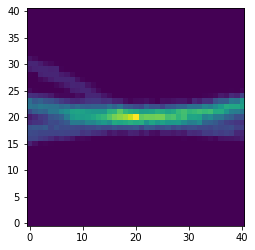

In [38]:
plt.imshow(stack, origin='lower')

## Another example

In [20]:
def add_diag_line(inmap, xpix_start_list, ypix_start_list, pixlen, pixthickness):
    # zero the map
    inmap[:,:] = 0
    # add a diagonal line of pixels to the new map
    diag_pixels = []
    for p in range(pixthickness):
        for m, xpix_start in enumerate(xpix_start_list):
            for i in range(pixlen):
                inmap[xpix_start+p+i, ypix_start_list[m]+i] = 1
                diag_pixels.append([xpix_start+i, ypix_start_list[m]+i])

    return inmap, diag_pixels


In [21]:
decs_rand = np.random.choice(np.arange(-50,10), size=50)
ras_rand  = np.random.choice(np.arange(-160,160), size=50)
from astropy.coordinates import Angle
import astropy.units as u
ras_rand = Angle(ras_rand * u.deg)
ras_rand = ras_rand.wrap_at(360 * u.deg).degree

ypix, xpix=enmap.sky2pix(shape, wcs, (np.radians(decs_rand), np.radians(ras_rand)))
diaglines, diagpix = add_diag_line(diagline, np.round(ypix).astype(int), np.round(xpix).astype(int), 100, 10)

In [22]:
pt_visual = mask_srcs(shape,wcs,np.asarray((np.radians(decs_rand),np.radians(ras_rand))),30.)


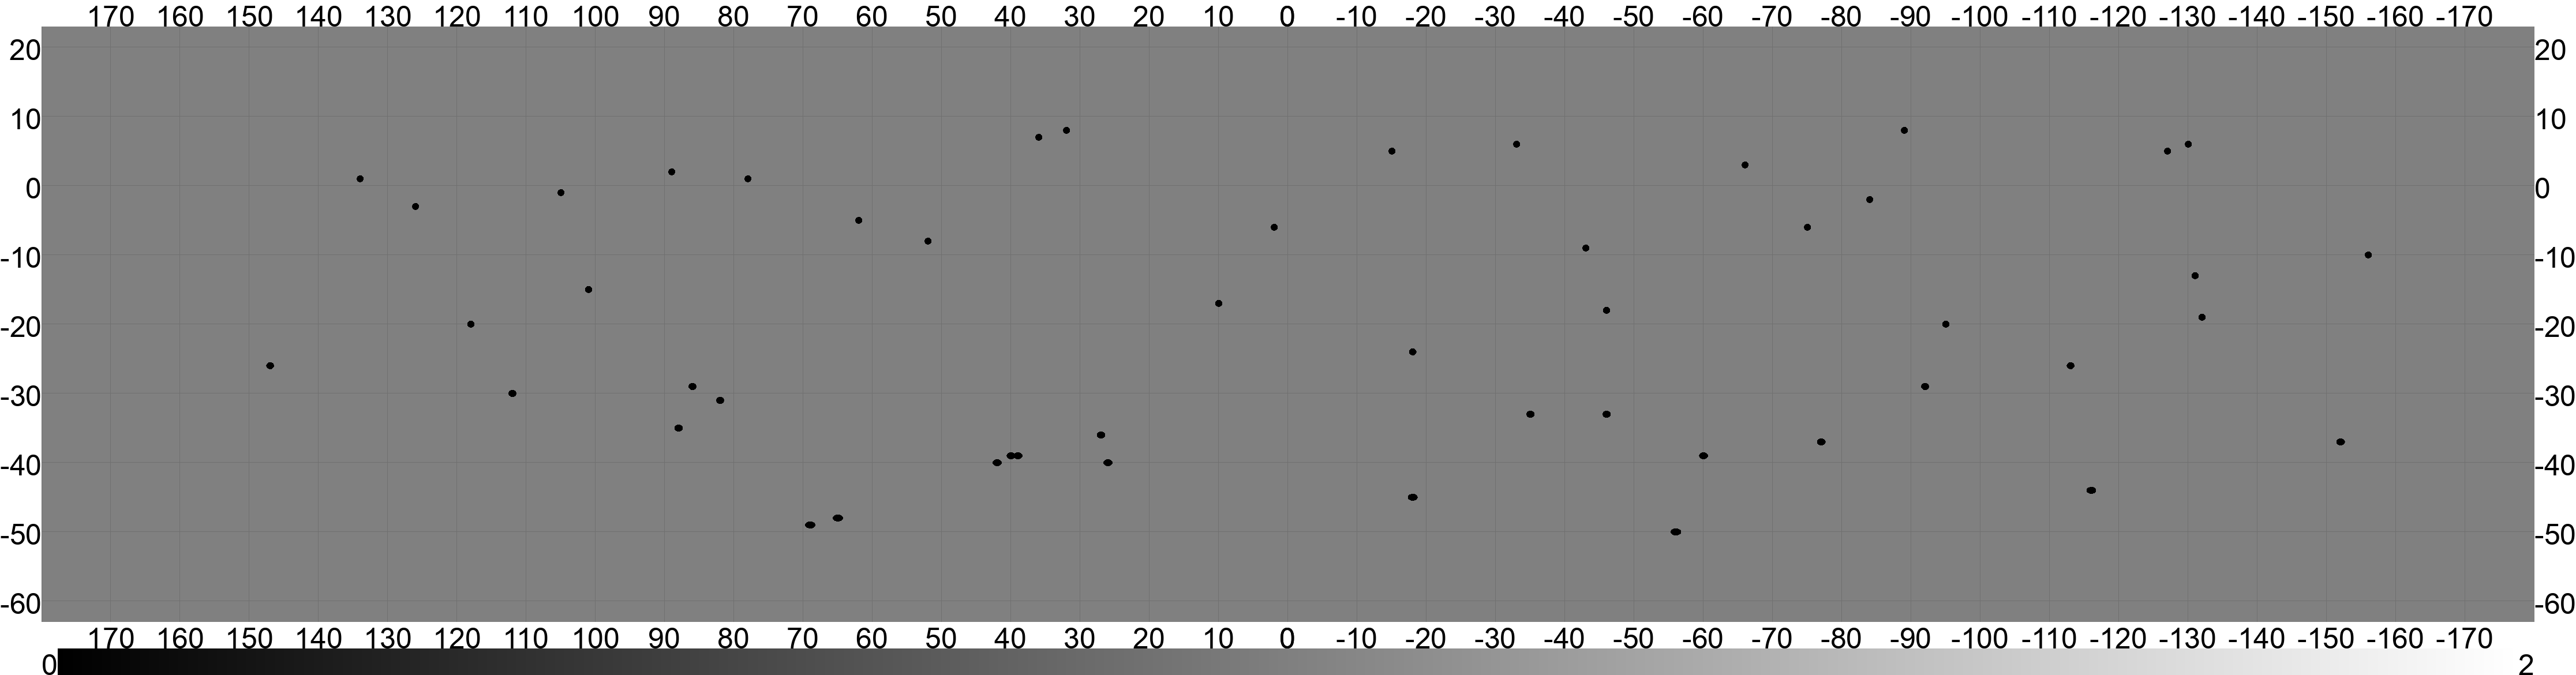

In [23]:
eshow(pt_visual, colorbar=True, ticks=10,  color='gray', font_size=50)

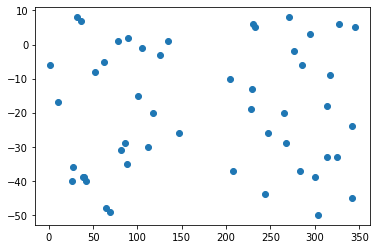

In [24]:
plt.scatter(ras_rand, decs_rand)

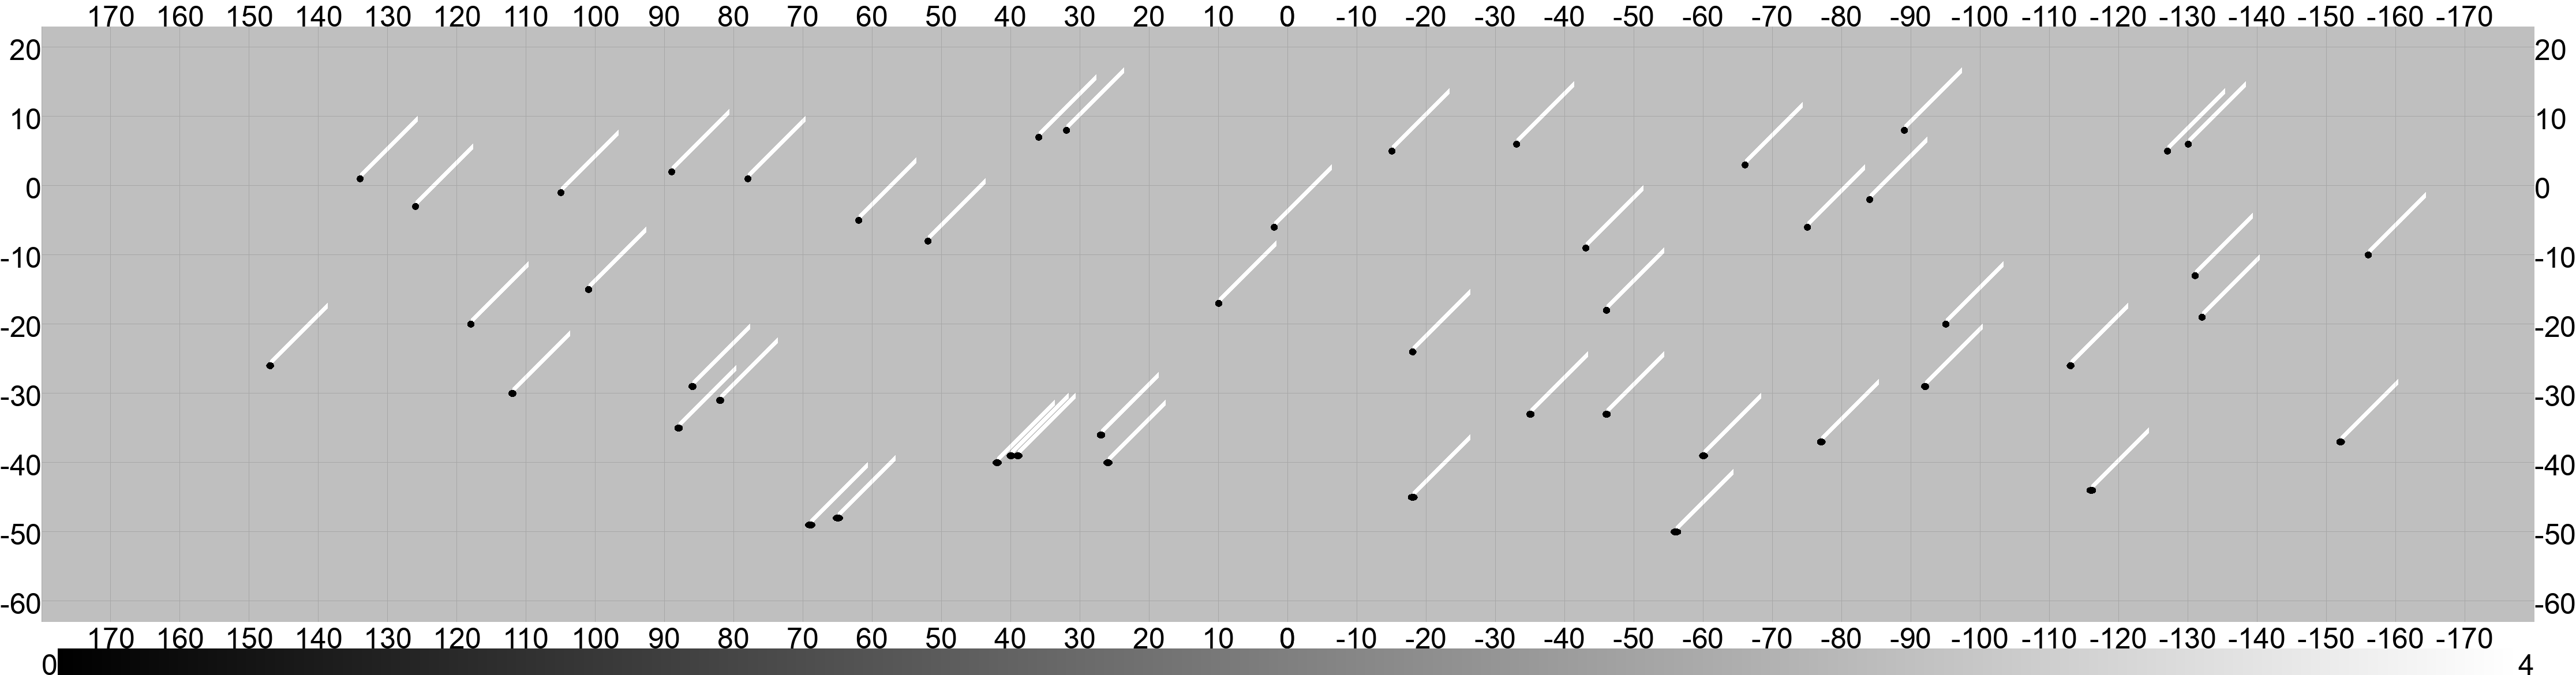

In [25]:
eshow((diaglines+3)*pt_visual, colorbar=True, min=0, ticks=10,  color='gray',font_size=50)

In [26]:
enmap.write_map("/mnt/raid-cita/mlokken/data/many_diagonal_lines_single_direction_map.fits", diaglines)


In [27]:
# save the points as both an (ra,dec) list and a (theta,phi) list
np.savetxt("testing_data/ra_dec_list_manydiag.txt", np.asarray((ras_rand,decs_rand)).T)
healpix_theta = np.pi/2. - np.radians(decs_rand)
healpix_phi = np.radians(ras_rand)
np.savetxt("testing_data/theta_phi_list_manydiag.txt", np.asarray((healpix_theta,healpix_phi)).T)

In [31]:
new_hmap = reproject.map2healpix(diaglines, nside=2048, lmax=3*2048, method='spline')
hp.write_map("/mnt/raid-cita/mlokken/data/many_diagonal_lines_single_direction_map_hpx.fits", new_hmap, overwrite=True, dtype=np.float32)


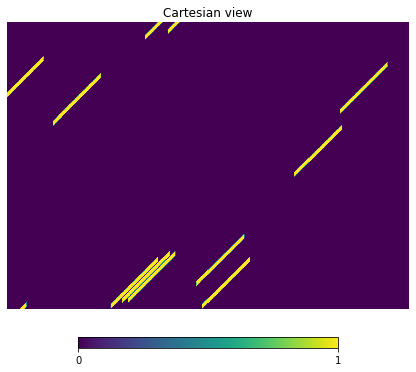

In [32]:
hp.cartview(new_hmap, lonra=[-10,60], latra=[-40,10])


# Start analysis comparison from here

In [53]:
diaglines = enmap.read_map("/mnt/raid-cita/mlokken/data/many_diagonal_lines_single_direction_map.fits")
rot_angle,ra,dec, parityx, parityy, peakid = cpp.get_peakinfo("/home/mlokken/oriented_stacking/oriented_superclustering/testing/testing_data/many_diag_line_singledir_pks_with_orientation_sym.fits")

FORMAT  =HEALPIX                                                                 [astropy.io.fits.card]
MAP     =/mnt/raid-cita/mlokken/data/many_diagonal_lines_single_direction_map_hp [astropy.io.fits.card]
FWHM    =0.                                                                      [astropy.io.fits.card]
OUTPUT  =/home/mlokken/oriented_stacking/oriented_superclustering/testing/testin [astropy.io.fits.card]
EXTERNAL=/home/mlokken/oriented_stacking/oriented_superclustering/testing/testin [astropy.io.fits.card]
NU_MIN  =-1.e30                                                                  [astropy.io.fits.card]
NU_MAX  =1.e30                                                                   [astropy.io.fits.card]
FWHM_NU =0.                                                                      [astropy.io.fits.card]
E_MIN   =0                                                                       [astropy.io.fits.card]
E_MAX   =1.e30                                                  

In [67]:
# make a Chunk object
Chunk = sf.Chunk(ra, dec, rot_angle, parityx, parityy)
orient = 'symmetric'
cutout_size_deg = 10
cutout_resolution_deg = 0.5


# Stack
stack = sf.stackChunk(Chunk, diaglines, cutout_size_deg, cutout_resolution_deg, orient)

x_lrg shape is (43,) y_lrg shape is (43,) thumbnail shape is (43, 43)
- analyze object 0


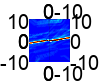

0.17279243485515913 6.101936896986616 -0.1786068004610003 0.18691947411690304


In [47]:
eshow(stack, ticks=10)
# get min, max ra, dec from stack
ra_min = enmap.pix2sky(stack.shape, stack.wcs, [0,0])[1]
ra_max = enmap.pix2sky(stack.shape, stack.wcs, [0,stack.shape[1]])[1]
dec_min = enmap.pix2sky(stack.shape, stack.wcs, [0,0])[0]
dec_max = enmap.pix2sky(stack.shape, stack.wcs, [stack.shape[0],0])[0]
print(ra_min, ra_max, dec_min, dec_max)


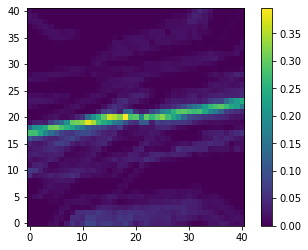

In [74]:
plt.imshow(np.flipud(np.fliplr(stack/Chunk.nObj)), origin='lower')
plt.colorbar()

FORMAT  =HEALPIX                                                                 [astropy.io.fits.card]
MAP     =/mnt/raid-cita/mlokken/data/many_diagonal_lines_single_direction_map_hp [astropy.io.fits.card]
FWHM_IN =0                                                                       [astropy.io.fits.card]
FWHM_PRE=0.                                                                      [astropy.io.fits.card]
PEAKS   =/home/mlokken/oriented_stacking/oriented_superclustering/testing/testin [astropy.io.fits.card]
FIELD   =I                                                                       [astropy.io.fits.card]
RADIUS  =10                                                                      [astropy.io.fits.card]
RES     =20                                                                      [astropy.io.fits.card]
OUTPUT  =/home/mlokken/oriented_stacking/oriented_superclustering/testing/testin [astropy.io.fits.card]
MMAX    =-1 # don't do a Hankel transform                       

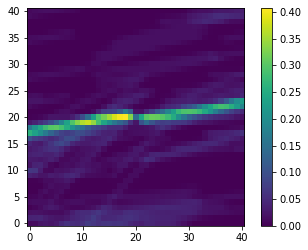

In [73]:
hdr, img, npks = cpp.get_img("/home/mlokken/oriented_stacking/oriented_superclustering/testing/testing_data/coop_stack_manylines_single_sym.fits", "/home/mlokken/oriented_stacking/oriented_superclustering/testing/testing_data/many_diag_line_singledir_pks_with_orientation_sym.fits")
plt.imshow(img, origin='lower')
plt.colorbar()

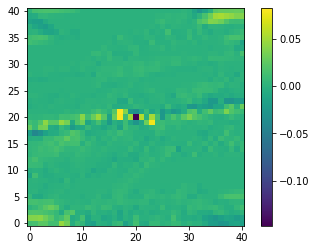

In [76]:
plt.imshow(img-np.flipud(np.fliplr(stack/Chunk.nObj)), origin='lower')
plt.colorbar()
# very similar except maybe some reprojection differences

In [41]:
# radius in COOP has to be twice the size that I expect for these to match...

Now do the same for asymmetry.

In [77]:
rot_angle,ra,dec, parityx, parityy, peakid = cpp.get_peakinfo("/home/mlokken/oriented_stacking/oriented_superclustering/testing/testing_data/many_diag_line_singledir_pks_with_orientation_asym.fits")
# make a Chunk object
Chunk = sf.Chunk(ra, dec, rot_angle, parityx, parityy)
orient = 'asymmetric'
cutout_size_deg = 10
cutout_resolution_deg = 0.5


# Stack
stack = sf.stackChunk(Chunk, diaglines, cutout_size_deg, cutout_resolution_deg, orient)

FORMAT  =HEALPIX                                                                 [astropy.io.fits.card]
MAP     =/mnt/raid-cita/mlokken/data/many_diagonal_lines_single_direction_map_hp [astropy.io.fits.card]
FWHM    =0.                                                                      [astropy.io.fits.card]
OUTPUT  =/home/mlokken/oriented_stacking/oriented_superclustering/testing/testin [astropy.io.fits.card]
EXTERNAL=/home/mlokken/oriented_stacking/oriented_superclustering/testing/testin [astropy.io.fits.card]
NU_MIN  =-1.e30                                                                  [astropy.io.fits.card]
NU_MAX  =1.e30                                                                   [astropy.io.fits.card]
FWHM_NU =0.                                                                      [astropy.io.fits.card]
E_MIN   =0                                                                       [astropy.io.fits.card]
E_MAX   =1.e30                                                  

x_lrg shape is (43,) y_lrg shape is (43,) thumbnail shape is (43, 43)
- analyze object 0


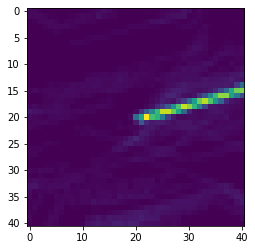

In [84]:
plt.imshow(stack)

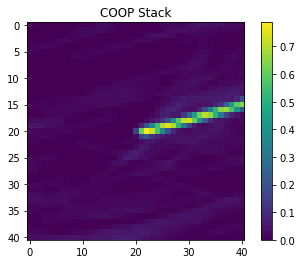

In [83]:
hdr, img, npks = cpp.get_img("/home/mlokken/oriented_stacking/oriented_superclustering/testing/testing_data/coop_stack_manylines_single_asym.fits", "/home/mlokken/oriented_stacking/oriented_superclustering/testing/testing_data/many_diag_line_singledir_pks_with_orientation_asym.fits")
plt.imshow(img)
plt.title("COOP Stack")
plt.colorbar()

In [ ]:
# the 1 vs -1 depends on whether you which RA orientation you want to use
# currently it is toward positive RA, and positive Dec, which I think is fine.

# Multidir lines

In [4]:
def generate_complex_map(inmap, xpix_start_list, ypix_start_list):
    # zero the map
    inmap[:,:] = 0
    pixthick1 = 10
    pixthick2 = 50
    # divide up the start position list
    npts = len(xpix_start_list)
    quarter = int(round(npts//4))
    eshow(inmap, colorbar=True)

    for p in range(pixthick1):
        pixlen1 = 50 + np.random.choice(np.arange(-10,10))
        for m, xpix_start in enumerate(xpix_start_list[:quarter]):
            for i in range(pixlen1):
                inmap[xpix_start+p+i, ypix_start_list[m]+i] = 1
    eshow(inmap, colorbar=True)
    for p in range(pixthick2):
        pixlen2 = 100 + np.random.choice(np.arange(-50,50))
        for m, xpix_start in enumerate(xpix_start_list[quarter:2*quarter]):
            for i in range(pixlen2):
                inmap[xpix_start+p+i, ypix_start_list[m]-i] = 1
                
    for p in range(pixthick1):
        pixlen1 = 50 + np.random.choice(np.arange(-10,10))
        for m, xpix_start in enumerate(xpix_start_list[2*quarter:3*quarter]):
            for i in range(pixlen1):
                inmap[xpix_start+p-i, ypix_start_list[m]+i] = 1
    eshow(inmap, colorbar=True)

    for p in range(pixthick2):
        pixlen2 = 100 + np.random.choice(np.arange(-50,50))
        for m, xpix_start in enumerate(xpix_start_list[3*quarter:]):
            for i in range(pixlen2):
                inmap[xpix_start+p-i, ypix_start_list[m]-i] = 1
    eshow(inmap, colorbar=True)

#     for p in range(pixthick1):
#         pixlen1 = 50 + np.random.choice(np.arange(-10,10))
#         for m, xpix_start in enumerate(xpix_start_list[2*quarter:3*quarter]):
#             for i in range(pixlen1):
#                 inmap[xpix_start+p, ypix_start_list[m]+i] = 1

#     for p in range(pixthick2):
#         pixlen2 = 100 + np.random.choice(np.arange(-50,50))
#         for m, xpix_start in enumerate(xpix_start_list[3*quarter:]):
#             for i in range(pixlen2):
#                 inmap[xpix_start+p-i, ypix_start_list[m]] = 1
    
#     for p in range(pixthick1):
#         pixlen1 = 50 + np.random.choice(np.arange(-10,10))
#         for m, xpix_start in enumerate(xpix_start_list[2*quarter:3*quarter]):
#             for i in range(pixlen1):
#                 inmap[xpix_start+p, ypix_start_list[m]+2*i] = 1

#     for p in range(pixthick2):
#         pixlen2 = 100 + np.random.choice(np.arange(-50,50))
#         for m, xpix_start in enumerate(xpix_start_list[3*quarter:]):
#             for i in range(pixlen2):
#                 inmap[xpix_start+p-2*i, ypix_start_list[m]] = 1
# #     randmap = enmap.rand_gauss(shape, wcs, dtype=np.float32)
    
    return inmap

def add_diag_line(inmap, xpix_start_list, ypix_start_list, pixlen, pixthickness):
    # zero the map
    inmap[:,:] = 0
    # add a diagonal line of pixels to the new map
    diag_pixels = []
    for p in range(pixthickness):
        for m, xpix_start in enumerate(xpix_start_list):
            for i in range(pixlen):
                inmap[xpix_start+p+i, ypix_start_list[m]+i] = 1
                diag_pixels.append([xpix_start+i, ypix_start_list[m]+i])

    return inmap, diag_pixels



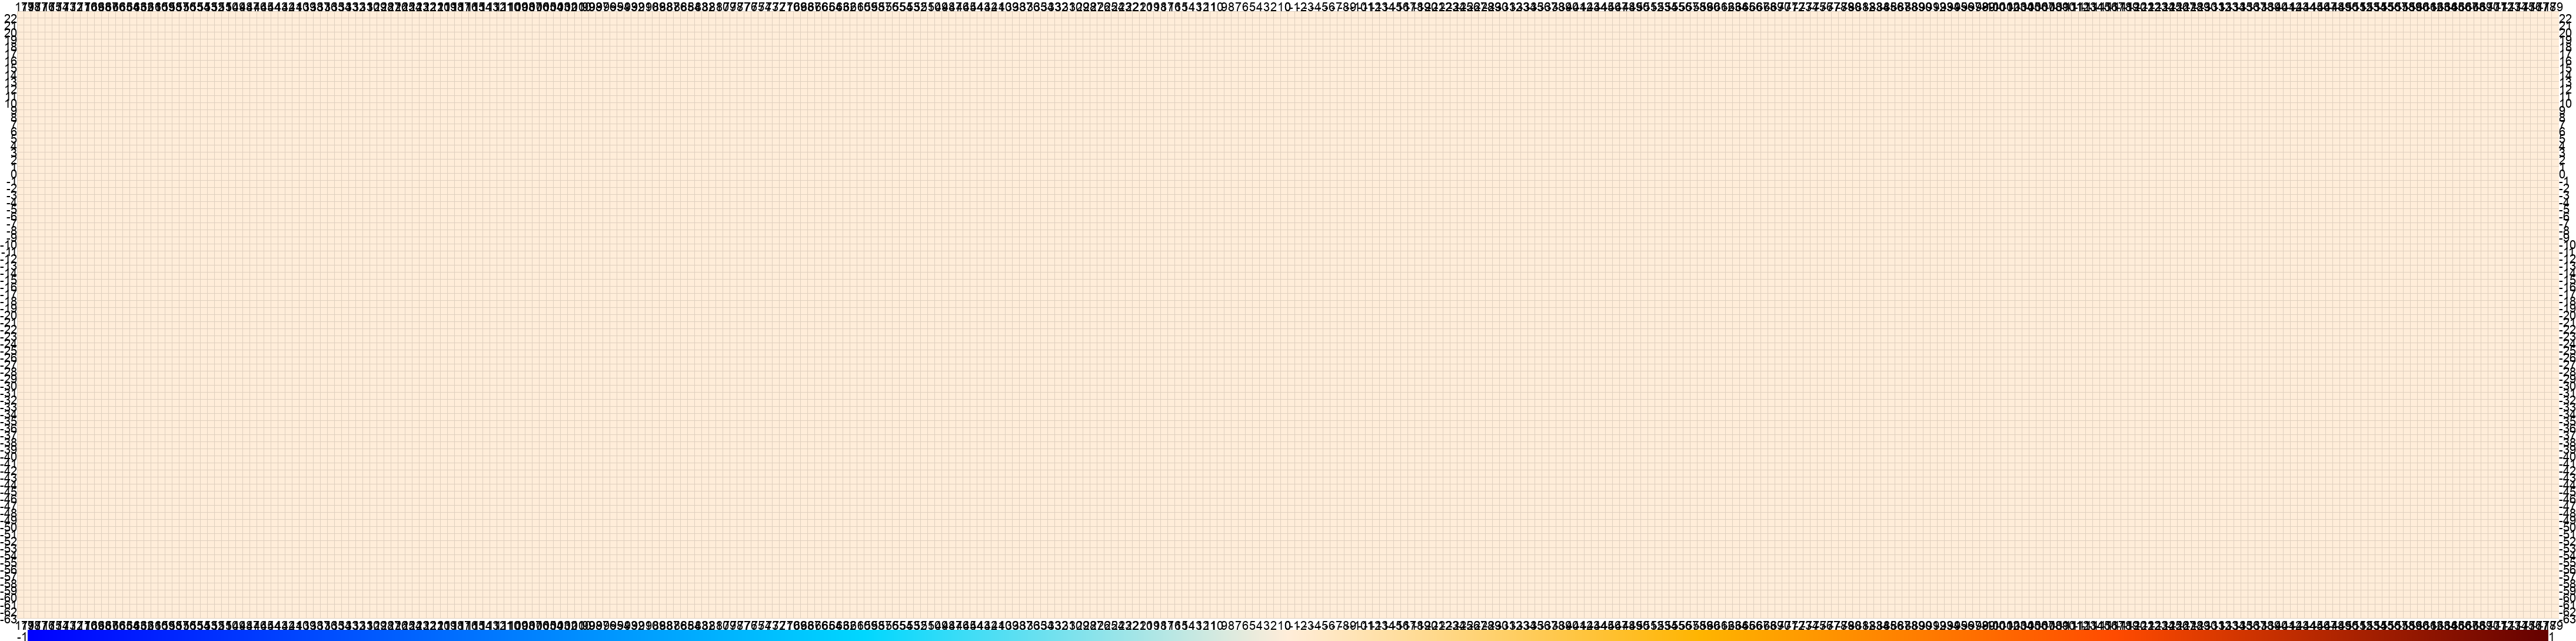

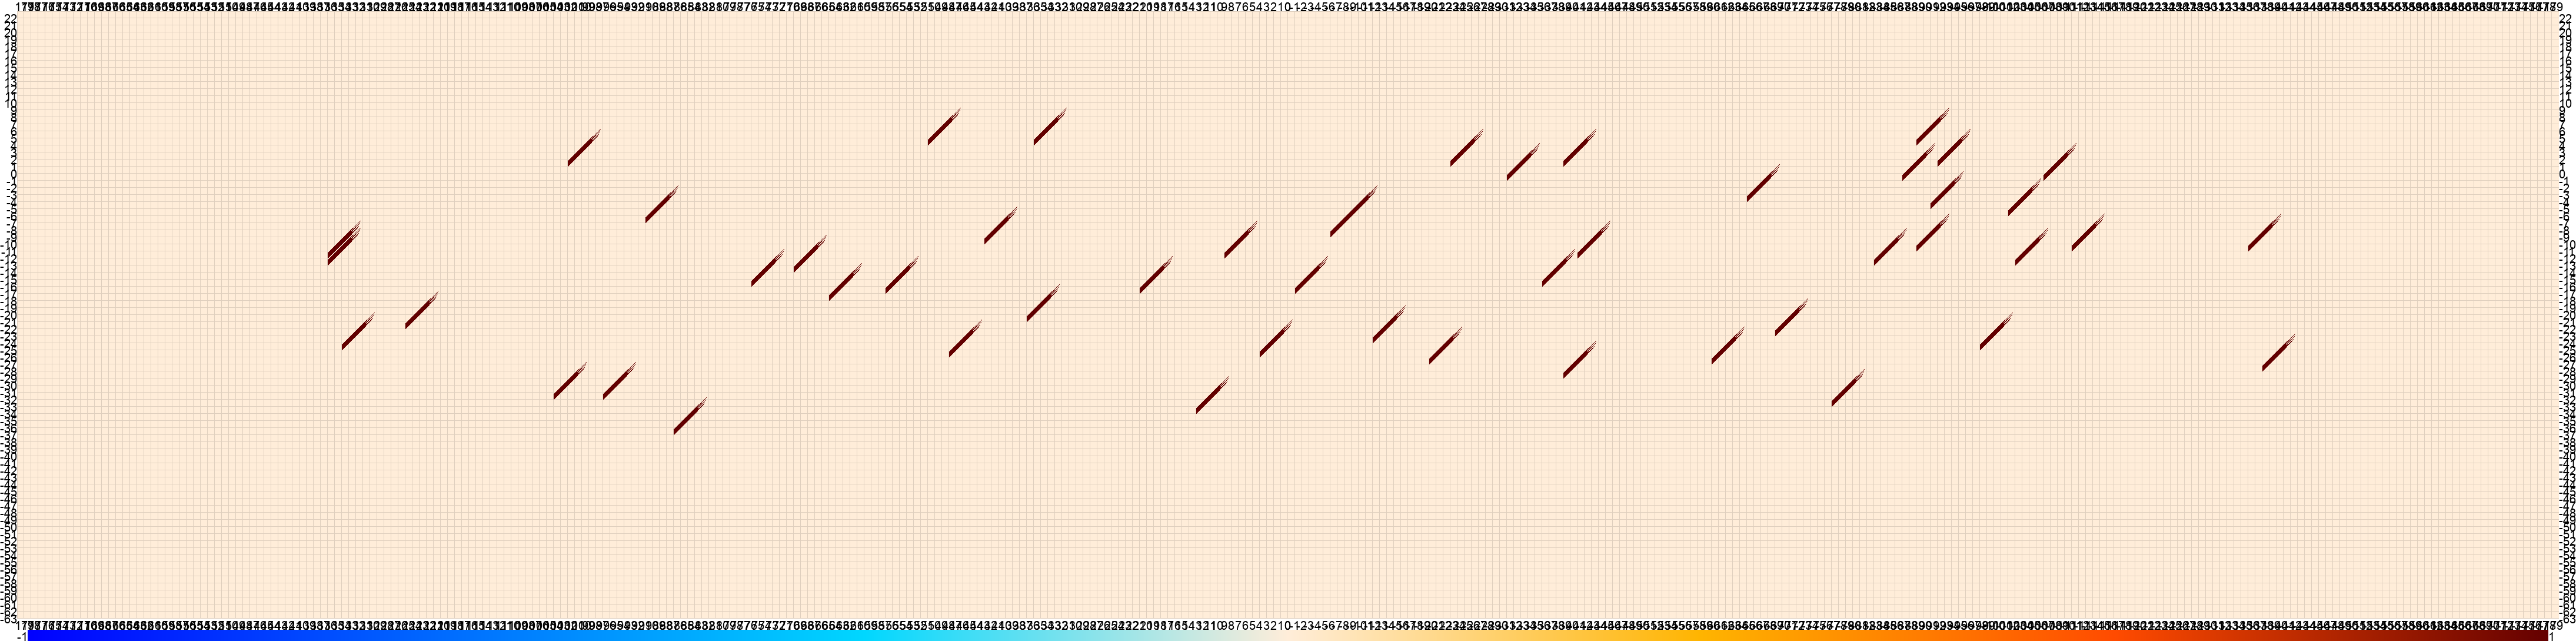

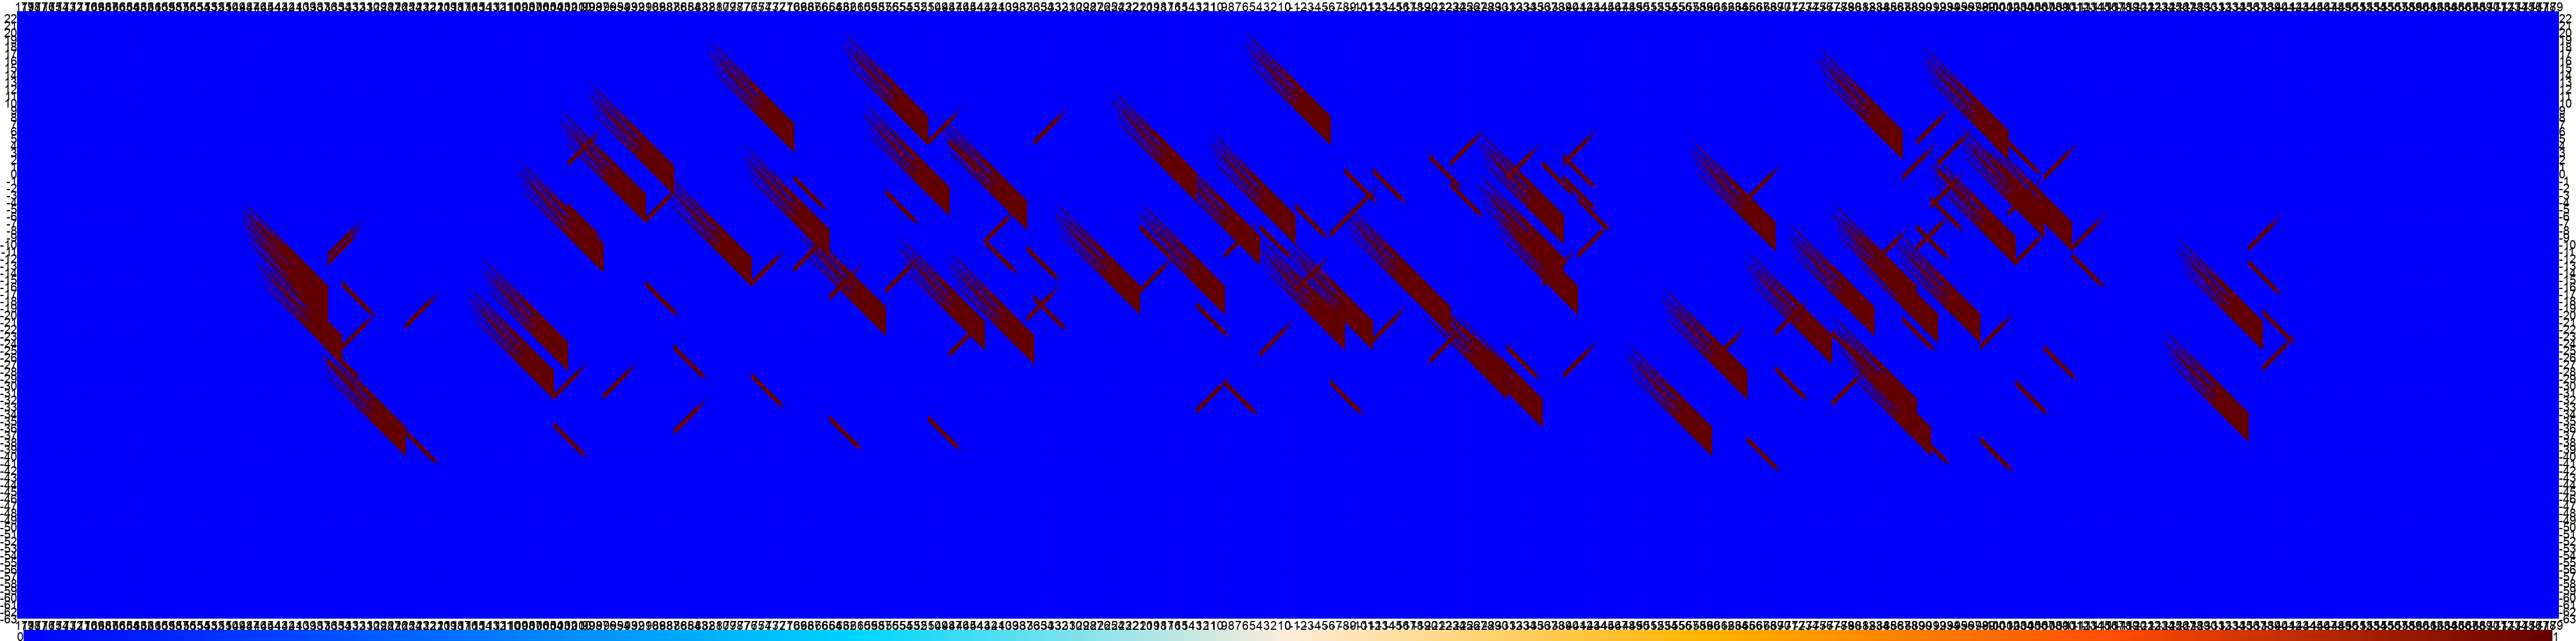

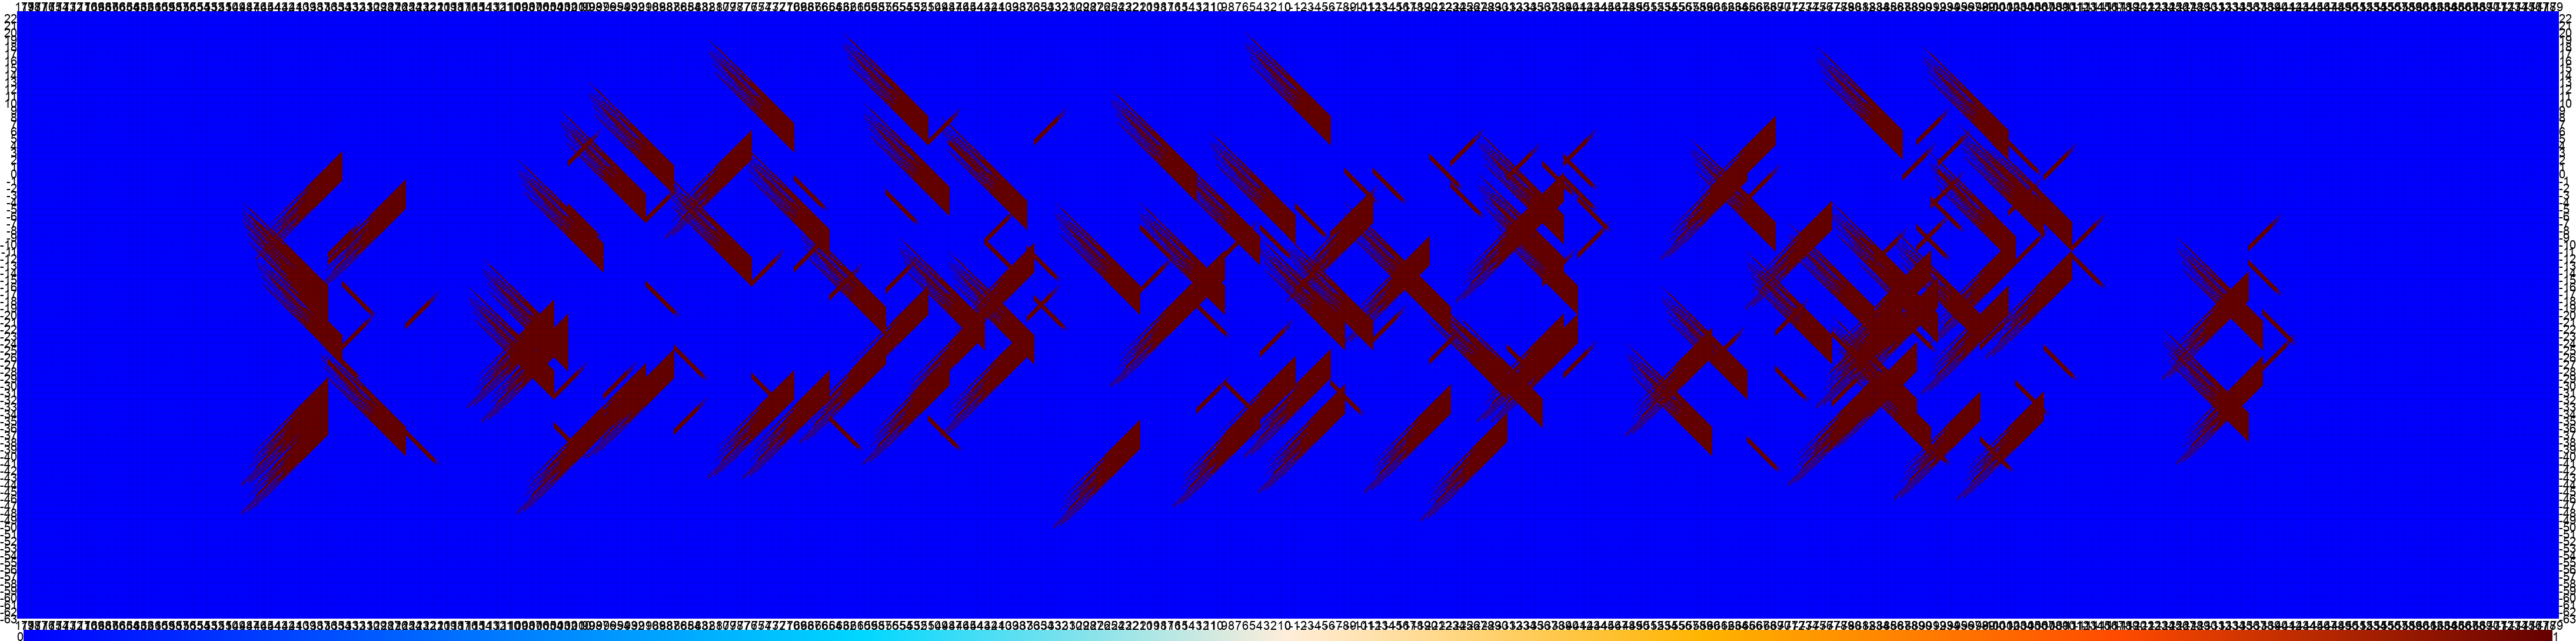

In [5]:
decs_rand = np.random.choice(np.arange(-40,5), size=200)
ras_rand  = np.random.choice(np.arange(-140,140), size=200)
from astropy.coordinates import Angle
import astropy.units as u
ras_rand = Angle(ras_rand * u.deg)
ras_rand = ras_rand.wrap_at(360 * u.deg).degree

ypix, xpix=enmap.sky2pix(shape, wcs, (np.radians(decs_rand), np.radians(ras_rand)))
diaglines = generate_complex_map(diagline, np.round(ypix).astype(int), np.round(xpix).astype(int))

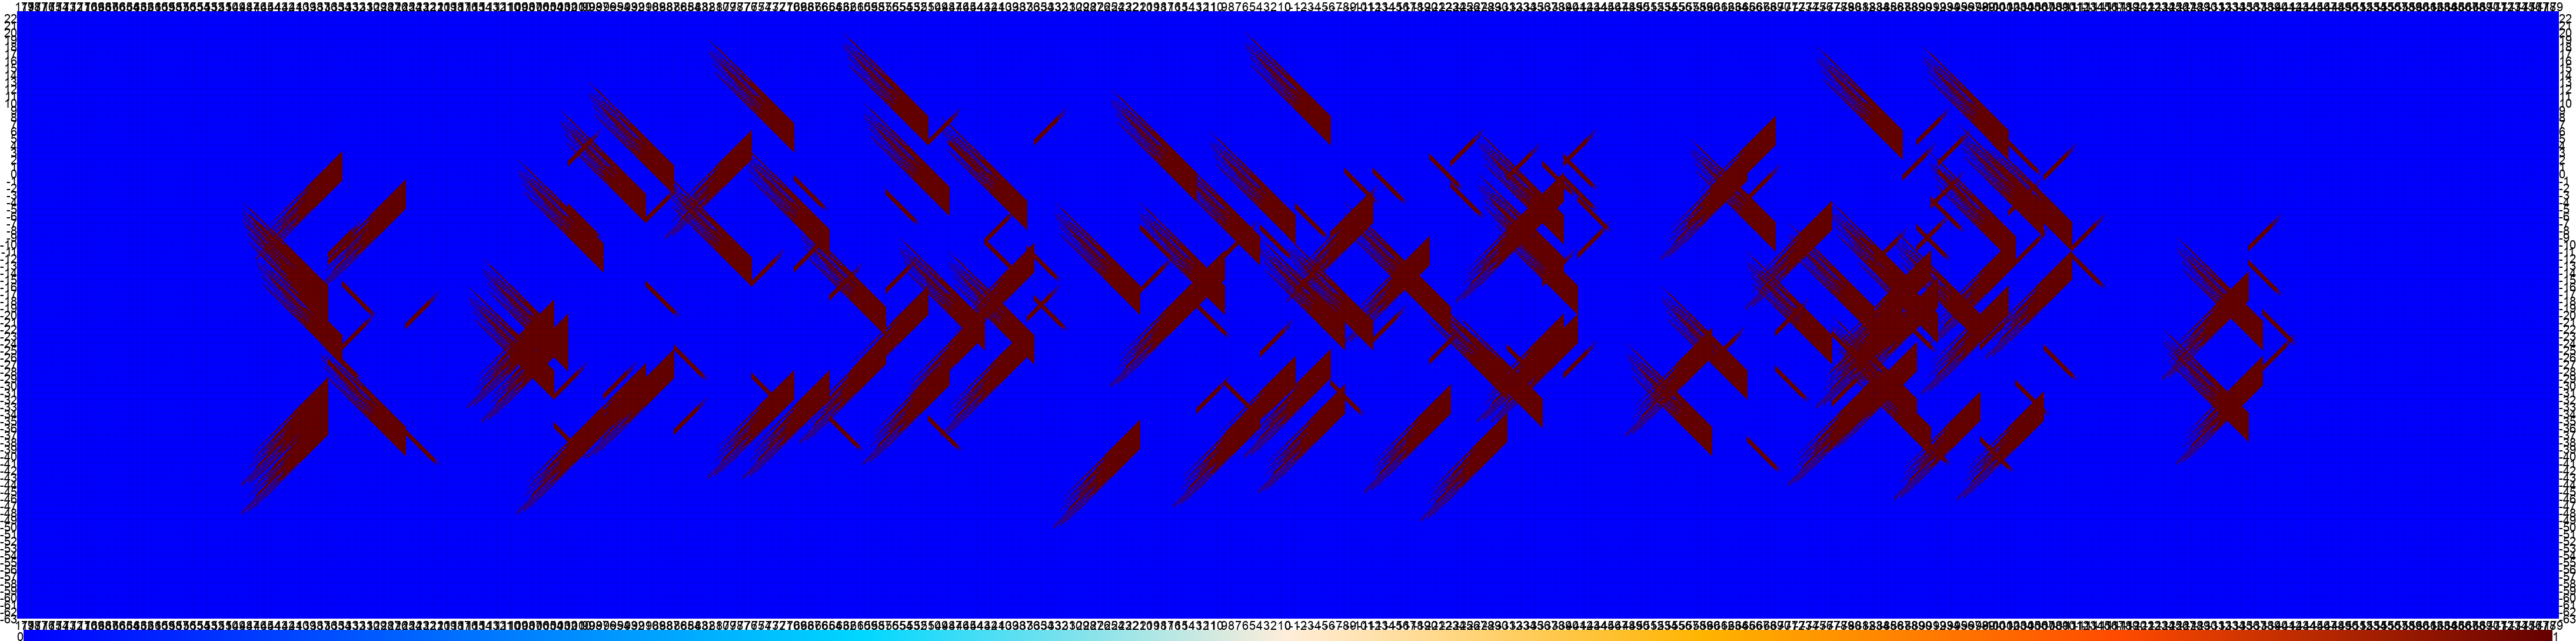

In [6]:
eshow(diaglines, colorbar=True)

In [7]:
enmap.write_map("/mnt/raid-cita/mlokken/data/many_diagonal_lines_multi_direction_map.fits", diaglines)


In [8]:
new_hmap = reproject.map2healpix(diaglines, nside=2048, lmax=3*2048, method='spline')



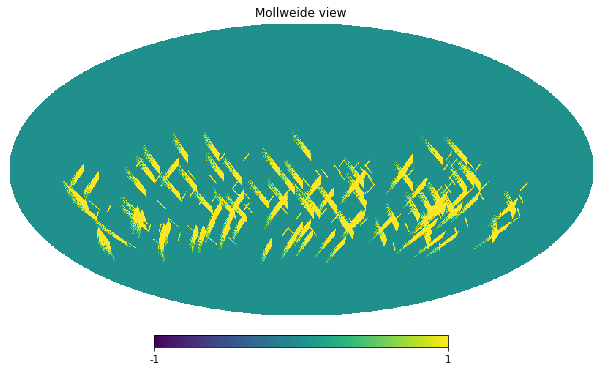

In [9]:
hp.mollview(new_hmap, min=-1, max=1)

In [11]:
hp.write_map("/mnt/raid-cita/mlokken/data/many_diagonal_lines_multi_direction_map_hpx.fits", new_hmap, overwrite=True, dtype=np.float32)

In [12]:
# save the points as both an (ra,dec) list and a (theta,phi) list
np.savetxt("testing_data/ra_dec_list_manydiag_multidir.txt", np.asarray((ras_rand,decs_rand)).T)
healpix_theta = np.pi/2. - np.radians(decs_rand)
healpix_phi = np.radians(ras_rand)
np.savetxt("testing_data/theta_phi_list_manydiag_multidir.txt", np.asarray((healpix_theta,healpix_phi)).T)

# Start analysis here

In [85]:
diaglines2 = enmap.read_map("/mnt/raid-cita/mlokken/data/many_diagonal_lines_multi_direction_map.fits")


In [86]:
rot_angle,ra,dec, parityx, parityy, peakid = cpp.get_peakinfo("/home/mlokken/oriented_stacking/oriented_superclustering/testing/testing_data/many_diag_line_multi_pks_with_orientation_asym.fits")


FORMAT  =HEALPIX                                                                 [astropy.io.fits.card]
MAP     =/mnt/raid-cita/mlokken/data/many_diagonal_lines_multi_direction_map_hpx [astropy.io.fits.card]
FWHM    =0.                                                                      [astropy.io.fits.card]
OUTPUT  =/home/mlokken/oriented_stacking/oriented_superclustering/testing/testin [astropy.io.fits.card]
EXTERNAL=/home/mlokken/oriented_stacking/oriented_superclustering/testing/testin [astropy.io.fits.card]
NU_MIN  =-1.e30                                                                  [astropy.io.fits.card]
NU_MAX  =1.e30                                                                   [astropy.io.fits.card]
FWHM_NU =0.                                                                      [astropy.io.fits.card]
E_MIN   =0                                                                       [astropy.io.fits.card]
E_MAX   =1.e30                                                  

In [87]:
# make a Chunk object
Chunk = sf.Chunk(ra, dec, rot_angle, parityx, parityy)
orient = 'asymmetric'
cutout_size_deg = 5
cutout_resolution_deg = 0.25


# Stack
stack = sf.stackChunk(Chunk, diaglines2, cutout_size_deg, cutout_resolution_deg, orient)

x_lrg shape is (45,) y_lrg shape is (45,) thumbnail shape is (45, 45)
- analyze object 0


In [1]:
plt.imshow(stack/Chunk.nObj)
plt.colorbar()

NameError: name 'plt' is not defined

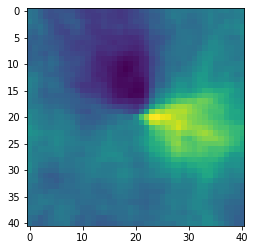

In [90]:
hdr, img, npks = cpp.get_img("/home/mlokken/oriented_stacking/oriented_superclustering/testing/testing_data/coop_stack_manylines_multi_asym.fits", "/home/mlokken/oriented_stacking/oriented_superclustering/testing/testing_data/many_diag_line_multi_pks_with_orientation_asym.fits")
plt.imshow(img)

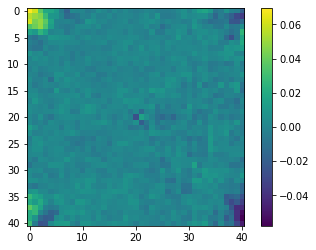

In [91]:
plt.imshow(img-stack/Chunk.nObj)
plt.colorbar()